In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import gc
from functools import partial
import time
import pickle
from imp import reload
from os.path import join
from itertools import product

from sklearn.model_selection import KFold
import numpy as np
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf

from data_loaders import Brats2015, Brats2017
import medim
from models_tf import DeepMedic, ModelController

%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
def compute_dices(y_pred, y_true):
    dices = []
    for yo_pred, yo_true in zip(y_pred, y_true):
        msegm_true = data_loader.segm2msegm(yo_true)
        msegm_pred = data_loader.segm2msegm(yo_pred)
        dices.append([medim.metrics.dice_score(msegm_pred[k], msegm_true[k])
                      for k in range(n_chans_msegm)])
    return np.mean(dices, axis=0)

In [4]:
brats2017 = True
brats2015 = not brats2017

if brats2017:
    processed_path = '/mount/export/brats2017/processed'
    data_loader = Brats2017(processed_path)
elif brats2015:
    processed_path = '/mount/export/brats2015/processed'
    data_loader = Brats2015(processed_path)
else:
    assert False

patients = data_loader.patients

x = []
y = []

for patient in tqdm(patients):
    x.append(data_loader.load_mscan(patient))
    y.append(data_loader.load_segm(patient))
    
n_modalities = data_loader.n_modalities
n_chans_msegm = data_loader.n_chans_msegm
n_classes = data_loader.n_classes

n_modalities, n_chans_msegm, n_classes

(4, 3, 4)

In [5]:
n_splits_train = 5
n_splits_val = 40

cv = KFold(n_splits_train, shuffle=True, random_state=42)
train, test = next(cv.split(y))

def extract(l, idx):
    return [l[i] for i in idx]

x_train, x_test = extract(x, train), extract(x, test)
y_train, y_test = extract(y, train), extract(y, test)

cv = KFold(n_splits_val, shuffle=True, random_state=21)
train, val = next(cv.split(x_train))

x_train, x_val = extract(x_train, train), extract(x_train, val)
y_train, y_val = extract(y_train, train), extract(y_train, val)

In [6]:
kernel_size = 3

patch_size_x_det = np.array([25, 25, 25])
patch_size_x_con = np.array([19, 19, 19]) * 3

patch_size_y = np.array([5, 5, 5])

In [7]:
x[0].shape

(4, 157, 189, 149)

In [34]:
y_padding = np.array([(0, 0)] * 2 + [(1, 1), (0, 0), (0, 1)])
padding = patch_size_x_det - patch_size_y
x_det_padding = [(0, 0)] * 2 + [(p//2, p//2 + (p % 2)) for p in padding]
x_det_padding += y_padding

padding = y_padding.copy()

x_con_padding = y_padding.copy()
x_con_padding[2:] += 26

#x_con_padding[2:, 0] -= 1
x_det_padding[2:] += 1
y_padding[2:] += 1

y_padding = y_padding[1:]

In [35]:
y_padding, x_det_padding, x_con_padding

(array([[0, 0],
        [2, 2],
        [1, 1],
        [1, 2]]), array([[ 0,  0],
        [ 0,  0],
        [12, 12],
        [11, 11],
        [11, 12]]), array([[ 0,  0],
        [ 0,  0],
        [27, 27],
        [26, 26],
        [26, 27]]))

In [36]:
%%time

# def symmetrical_padding(x, padding):
#     # 3-dimentional spatial
#     non_spatial = x.ndim - 3
#     padding = np.array(padding)
    
#     padding = list(zip(padding, padding))
#     padding = [(0, 0)] * non_spatial + padding
    
#     return np.pad(x, padding, mode='constant')

x_det_val_padded = np.pad(x_val, x_det_padding, mode='constant')
x_con_val_padded = np.pad(x_val, x_con_padding, mode='constant')
y_val_padded = np.pad(y_val, y_padding, mode='constant')

CPU times: user 1.24 s, sys: 13.5 s, total: 14.7 s
Wall time: 14.4 s


In [37]:
x_det_val_padded.shape, x_con_val_padded.shape, y_val_padded.shape

((6, 4, 181, 211, 172), (6, 4, 211, 241, 202), (6, 161, 191, 152))

In [38]:
log_path = '/tmp/tf'

restore_ckpt_path = None#'./checkpoints/ee-net'

tf.reset_default_graph()
model = DeepMedic(n_modalities, n_classes)
model_controller = ModelController(model, log_path, restore_ckpt_path)

Tensor("deep_medic/Shape:0", shape=(5,), dtype=int32)


In [39]:
lr = 0.1
batch_size = 64

n_epoch = 100
n_batches_per_epoch = 20

def cond(y):
    return y > 0

train_iter = medim.batch_iter.patch.foreground(
        [x_train, y_train], [patch_size_x, patch_size_y], batch_size=batch_size,
        spatial_dims=(-3, -2, -1), f_fraction=0.5, f_condition=cond
)
    

for epoch in range(n_epoch):
    gc.collect()
    print('Epoch {}'.format(epoch), flush=True)
    
    train_loss = model_controller.train(train_iter, lr, n_batches_per_epoch)
    print('Train:', train_loss, flush=True)
    
    y_pred, val_loss = model_controller.validate([x_det_val_padded, x_con_val_padded],
                                                 y_val_padded)
    print('Val       :', val_loss)
    
    val_dices = compute_dices(y_pred, y_val_padded)
    print('Val dices :', val_dices)
    
    print('\n', flush=True)

Epoch 0
Train: 0.440774


ResourceExhaustedError: OOM when allocating tensor with shape[1,150,161,191,152]
	 [[Node: deep_medic/comm/block_b/conv3d/convolution = Conv3D[T=DT_FLOAT, data_format="NCDHW", padding="VALID", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](deep_medic/comm/block_b/Relu, deep_medic/comm/block_b/conv3d/kernel/read)]]
	 [[Node: loss/sparse_softmax_cross_entropy_loss/value/_161 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1775_loss/sparse_softmax_cross_entropy_loss/value", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'deep_medic/comm/block_b/conv3d/convolution', defined at:
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-90dcd713d496>", line 6, in <module>
    model = DeepMedic(n_modalities, n_classes)
  File "/home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/models_tf/deepmedic_orig.py", line 100, in __init__
    self.is_training, 'deep_medic')
  File "/home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/models_tf/deepmedic_orig.py", line 75, in build_model
    name='comm')
  File "/home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/models_tf/deepmedic_orig.py", line 35, in res_block
    t1 = bac(t1, n_chans, kernel_size, training, 'block_b')
  File "/home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/models_tf/deepmedic_orig.py", line 17, in bac
    use_bias=False)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 728, in conv3d
    return layer.apply(inputs)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 492, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 441, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 158, in call
    data_format=utils.convert_data_format(self.data_format, self.rank + 2))
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 670, in convolution
    op=op)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 662, in op
    name=name)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 146, in _non_atrous_convolution
    name=name)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 526, in conv3d
    data_format=data_format, name=name)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,150,161,191,152]
	 [[Node: deep_medic/comm/block_b/conv3d/convolution = Conv3D[T=DT_FLOAT, data_format="NCDHW", padding="VALID", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](deep_medic/comm/block_b/Relu, deep_medic/comm/block_b/conv3d/kernel/read)]]
	 [[Node: loss/sparse_softmax_cross_entropy_loss/value/_161 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1775_loss/sparse_softmax_cross_entropy_loss/value", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [30]:
y_pred_proba = model_controller.predict_proba(
    tqdm(map(partial(min_padding, padding=padding), x_test)))

KeyboardInterrupt: 

In [32]:
import gc

gc.collect()

1789

In [12]:
%%time

min_padding(x_test[0], padding)

CPU times: user 96 ms, sys: 1 s, total: 1.1 s
Wall time: 1.08 s


array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        ..., 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0., 

In [28]:
x_test[0].shape

(4, 157, 189, 149)

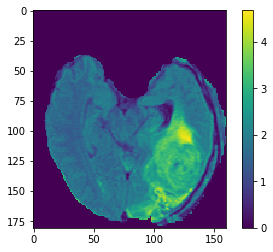

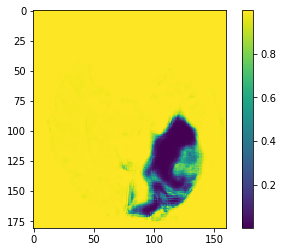

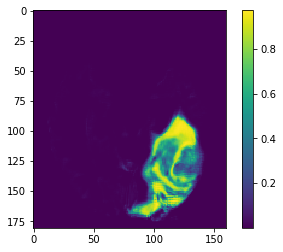

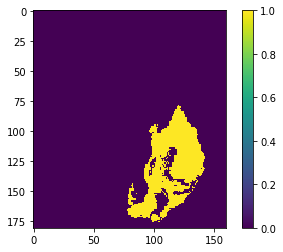

In [54]:
m = 40
k = 2

plt.imshow(x_test[0][3, m])
plt.colorbar()
plt.show()
plt.imshow(y_pred_proba[0][0][0, m])
plt.colorbar() 
plt.show()
plt.imshow(y_pred_proba[0][0][k, m])
plt.colorbar()
plt.show()
plt.imshow(y_test[0][m] == k)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(y_pred_proba[, )

In [ ]:
from joblib import Parallel, delayed

compute

Parallel(n_jobs=-1)((compute_dices, y_pred, y_test) for i in range(10))

In [16]:
y_pred = [np.argmax(y, axis=1) for y in y_pred_proba]

In [18]:
dices = compute_dices(y_pred, y_test)

In [9]:
y_pred, loss = model_controller.validate(x_val_padded, y_val_padded)

In [10]:
y_pred[0].shape

(139, 177, 143)

In [12]:
compute_dices(y_pred, y_val_padded)

array([ 0.80115887,  0.57093293,  0.76356091])

In [ ]:
def get_dice_threshold(y_preds, my):
    thresholds = []
    for i in range(n_classes):
        ps = np.linspace(0, 1, 100)
        best_p = 0
        best_score = 0
        for p in ps:
            score = np.mean([dice_score(pred[i] > p, true[i]) for pred, true in zip(y_preds, my)])
            if score is np.nan or None:
                print('None')
                score = 1
            
            if score > best_score:
                best_p = p
                best_score = score
        thresholds.append(best_p)
        print(best_score)
    return thresholds

thresholds = get_dice_threshold(y_preds, y_val)
thresholds

In [ ]:
y_preds_t = []

model.eval()
for mscan, msegm in tqdm(zip(x_test, y_test)):
    mscan = min_padding(mscan, padding)
    msegm = np.array(msegm, dtype=np.float32)

    mscan_parts = medim.utils.divide(mscan, padding, n_parts)
    msegm_parts = medim.utils.divide(msegm, [0, 0, 0], n_parts)

    predicted = []
    for mscan_part, msegm_part in zip(mscan_parts, msegm_parts):
        o = np.array(mscan_part[None, :])

        y_pred = model(to_var(o, volatile=True))
        loss = F.binary_cross_entropy(y_pred, to_var(msegm_part[None, :], volatile=True))
        
        predicted.append(to_numpy(y_pred)[0])

    y_pred = medim.utils.combine(predicted, n_parts)
    y_preds_t.append(y_pred)

In [ ]:
np.mean([[dice_score(y_preds_t[i][k] > thresholds[k], y_test[i][k]) for k in range(n_classes)]
         for i in range(len(y_preds_t))], axis=0)

In [ ]:
len(x_train), len(x_val), len(x_test)

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))

i = 4
k = 90

cmap = cm.GnBu
fontsize = 30

ax[0, 0].set_title('Predicted segmentation', fontsize=fontsize)
ax[0, 0].imshow(y_preds_t[i][0, ..., k], cmap=cmap)
#plt.colorbar()
#plt.show()
ax[0, 1].set_title('Ground truth', fontsize=fontsize)
ax[0, 1].imshow(y_test[i][0, ..., k], cmap=cmap)

ax[1,0].set_title('Brain slice', fontsize=fontsize)
ax[1, 0].imshow(x_test[i][3, ..., k], cmap=cmap)
plt.tight_layout()
ax[0, 0].axis('off')
ax[1, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 1].axis('off')
plt.show()
#plt.colorbar()
#plt.show()

In [10]:
def segm_log_loss(yo_pred, yo_true):
    y_pred = np.moveaxis(yo_pred, 0, 3).reshape((-1, n_classes))
    y_true = yo_true.flatten()
    return log_loss(y_true, y_pred)

In [ ]:
# def pred_reshape(y):
#     x = y.permute(0, 2, 3, 4, 1)
#     return x.contiguous().view(-1, x.size()[-1])

# def loss_cross_entropy(y_pred, y_true):
#     return F.cross_entropy(pred_reshape(y_pred), y_true.view(-1))


coeff = to_var(np.array([1, 2, 3], dtype=np.float32))
epsilon = 1e-7

def dice_loss(y_pred, target):
    y_pred = y_pred.view(*y_pred.size()[:2], -1)
    target = target.view(*target.size()[:2], -1)
    
#     s = y_pred.size()
#     e = epsilon.expand(s[0], 1, s[2])
    dice_scores = 2 * (epsilon + (y_pred * target).sum(2)) / \
                  (y_pred.sum(2) + target.sum(2) + 2 * epsilon)
        
    dice_scores = dice_scores.mean(0)
    dice_scores = dice_scores.view(-1)

    return -torch.sum(dice_scores * coeff)

In [ ]:
def predict_object(model, xo, n_parts_per_axis):
    model.eval()
    xo_parts = medim.utils.divide(xo, [0] + [*padding], n_parts_per_axis)

    xo_predicted = []
    for xo_part in xo_parts:
        xo_part = xo_part[None, :]

        y_pred = model(to_var(xo_part, volatile=True))

        xo_predicted.append(to_numpy(y_pred)[0])

    yo_pred = medim.utils.combine(xo_predicted, n_parts_per_axis)
    return yo_pred